# Imports

In [136]:
from __future__ import division
import os,time,pdb
import numpy as np
from itertools import cycle

#scikit-learn
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import roc_curve, auc

#nlp
import nltk, re, pprint
from nltk.stem import *
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = stopwords.words('english')
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline
# Set some default plotting parameters
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'gray'
mpl.rcParams['figure.figsize'] = (10, 10)
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize']  = 18
mpl.rcParams['legend.fontsize'] = 18

# Helper functions

In [203]:
def tokenize_it(text_list):
    return tokenizer.tokenize(text_list)
    #word_tokenize(text_list)

def stem_list(word_list):  
    words = tokenize_it(word_list)
    stem_list = []
    for word in words:
        if word not in stop :
            stem_list.append(stemmer.stem(word.lower()))
    return stem_list

def train_test_split(X,y,split=.8,seed=1234):
    np.random.seed(seed)
    m = X.shape[0]
    idx = np.random.permutation(np.arange(m))
    X, y = X[idx], y[idx]
    train = int(np.floor(m*split))
    return X[:train], X[train:], y[:train], y[train:]

def plot_ROC_curve(y_test,y_predict,label):
    fpr, tpr, _ = roc_curve(y_test,y_predict)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve of H$_1$="{0}" (area = {1:0.2f})'
             ''.format(label, roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(r'false positive rate ($\alpha$)')
    plt.ylabel(r'true positive rate or power ($1-\beta$)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Scrape the data from Reddit

In [180]:
subreddits = ['schizophrenia', 'depression']
X, y = datasets.scrape_comments(subreddits)
y-=1#to make it a binary vector


996 comments from subreddit: schizophrenia fetched!

968 comments from subreddit: depression fetched!


# Create the dictionary

In [45]:
vocabulary = {}
idx = 0
for i in xrange(len(X)):
    words = stem_list(X[i])
    for word in words:
        if word not in vocabulary:
            vocabulary[word]=idx
            idx+=1
v = len(vocabulary.keys())

# Multivariate Bernoulli NB event model

# Transform text to binary vectors (bag of words or BOW)

In [186]:
cv = CountVectorizer(vocabulary=vocabulary,binary=True)
X_cv = cv.fit_transform(X)

# Train test split

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X_cv,y,split=.8,seed=1234)

# Compute the prior probabilities $p(Y=k)$

The maximum likelihood (ML) estimator of the prior probabilities for different types of documents is simply the ratio of documents of that type over the total number of documents in the training set.

In [191]:
m = X_train.shape[0]
m0 = X_train[np.where(y_train==0)].shape[0]
m1 = X_train[np.where(y_train==1)].shape[0]

p_y0 = m0/m
p_y1 = m1/m

# Compute the likelihood probabilities $p(X_j=1|Y=k)$ 

According to the Naive Bayes assumption (the probability of a feature, a word in this case, is independent of the other features given the class, a property which is also knwon as conditional independence):
\begin{equation*}
p(X=x|Y=k) = p(X_1=x_1,X_2=x_2,...,X_{|V|}=x_{|V|}|Y=k) = \prod_{j=1}^{|V|}p(X_j=x_j|Y=k) = \prod_{j=1}^{|V|}\Theta_{j|y=k}^{x_j}(1-\Theta_{j|y=k})^{(1-x_j)}
\end{equation*}

The ML estimator of the likelihood probabilities $p(X_j=1|Y=k)$ is the number of documents of class $k$ that contain $X_j$ over all the documents of class $k$ in the training set. To avoid likelihood probabilities that are zero for words that do not appear in the training set, we use a technique called <i>Laplace smoothing</i>, which consists in adding a 1 to the nominator and $k=2$ to the denominator.

In [192]:
Theta = np.zeros((len(vocabulary),2))
Theta[:,0] = (X_train[np.where(y_train==0)].sum(0)+1)/(m0+2)
Theta[:,1] = (X_train[np.where(y_train==1)].sum(0)+1)/(m1+2)

# Compute the posterior probabilities $p(Y=k|X=x)$

According to Bayes' rule:
\begin{equation*}
p(Y=k|X=x) = \frac{p(X=x|Y=k)p(Y=k)}{p(X=x)} = \frac{p(X=x|Y=k)p(Y=k)}{\sum_{k=1}^{m}p(X=x|Y=k)p(Y=k)}
\end{equation*}


In [193]:
p_y_x = np.ones((X_test.shape[0],2))
p_y_x[:,0]*= p_y0
p_y_x[:,1]*= p_y1
for i in xrange(X_test.shape[0]):
    for j in xrange(X_test.shape[1]):
        p_y_x[i,0]*= (1-X_test[i,j])*(1-Theta[j,0]) + X_test[i,j]*Theta[j,0]
        p_y_x[i,1]*= (1-X_test[i,j])*(1-Theta[j,1]) + X_test[i,j]*Theta[j,1]
        d = p_y_x[i,0]+p_y_x[i,1]
        p_y_x[i,0]/=d
        p_y_x[i,1]/=d

# Evaluation of the multivariate Bernoulli NB model

In [194]:
print(metrics.classification_report(y_test, np.argmax(p_y_x,1),target_names=subreddits))

               precision    recall  f1-score   support

schizophrenia       0.82      0.55      0.66       194
   depression       0.67      0.88      0.76       199

  avg / total       0.74      0.72      0.71       393



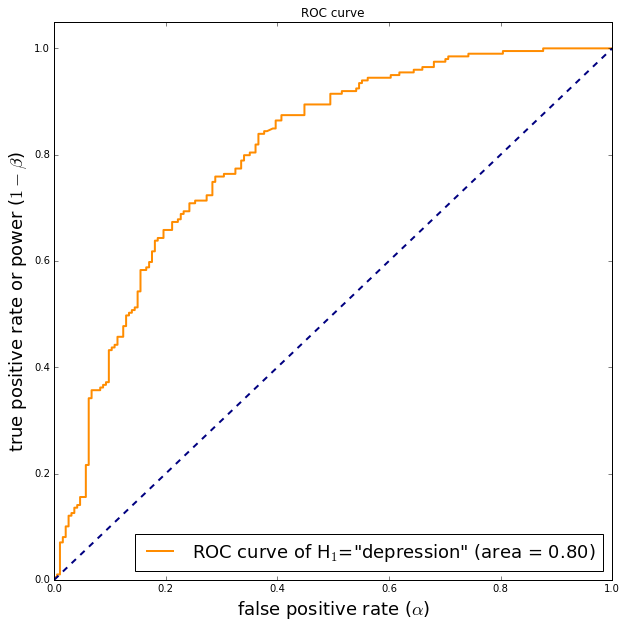

In [204]:
plot_ROC_curve(y_test,p_y_x[:,1],subreddits[1])

In [188]:
classifier = BernoulliNB(alpha=1.0, fit_prior=True, class_prior=None)
classifier.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [189]:
print(metrics.classification_report(y_test, classifier.predict(X_test),target_names=subreddits))

               precision    recall  f1-score   support

schizophrenia       0.82      0.55      0.66       194
   depression       0.67      0.88      0.76       199

  avg / total       0.74      0.72      0.71       393



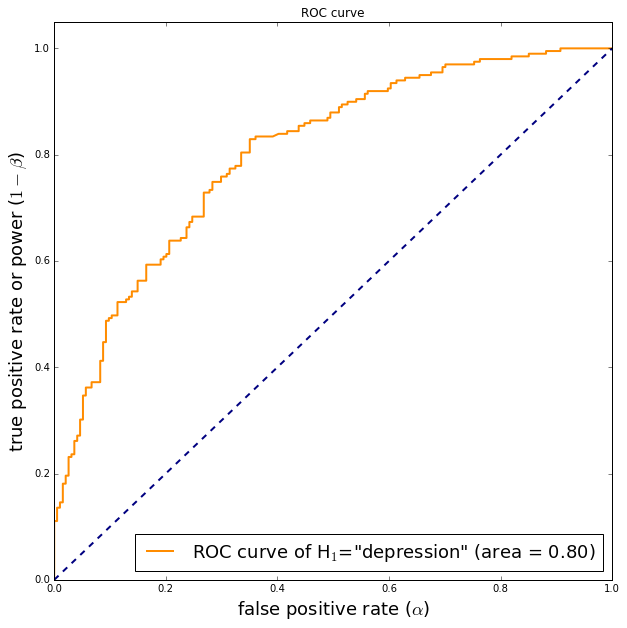

In [205]:
plot_ROC_curve(y_test,classifier.predict_proba(X_test)[:,1],subreddits[1])

# Multinomial NB event model

## Create count vectors $x^{(i)}$

In this case the features $x_j^{(i)}$ indicate the number of times that the word $j$ appeared in the document $i$

In [206]:
#cv = CountVectorizer(vocabulary=vocabulary,binary=False)
#X_cv = cv.fit_transform(X)
X_cv, _ = datasets.get_tfidf(X)

## Train-test split

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X_cv,y,split=.8,seed=1234)

# Compute the likelihood probabilities $p(x_j=n|y=k)$ 

The prior probabilities don't change in the multinomial case, so we can reuse the computations done above. However, the likelihood probabilities are different because we are using a Multinomial model (since we are modelling counts) as opposed to modeling Bernoulli binary variables. 

In [ ]:
Theta = np.zeros((len(vocabulary),2))
Theta[:,0] = (X_train[np.where(y_train==0)].sum(0)+1)/(m0+2)
Theta[:,1] = (X_train[np.where(y_train==1)].sum(0)+1)/(m1+2)

## scikit-learn's multinomial NB model

In [208]:
classifier = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [209]:
print(metrics.classification_report(y_test, classifier.predict(X_test),target_names=subreddits))

               precision    recall  f1-score   support

schizophrenia       0.85      0.69      0.76       194
   depression       0.74      0.88      0.81       199

  avg / total       0.80      0.79      0.78       393



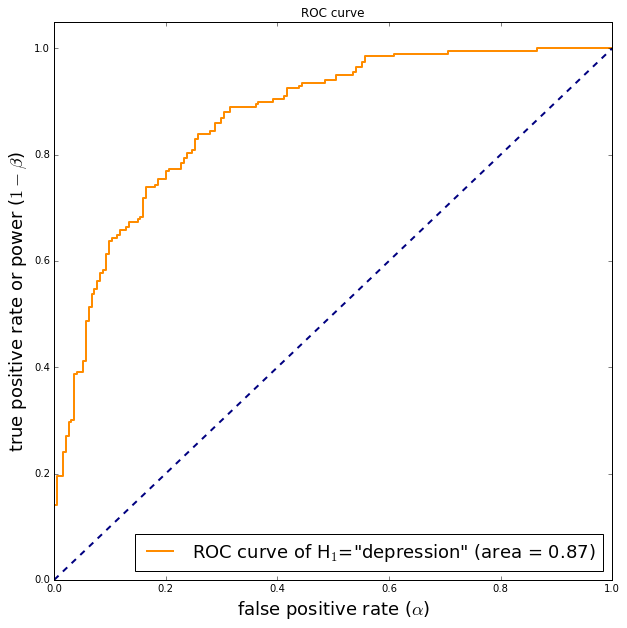

In [210]:
plot_ROC_curve(y_test,classifier.predict_proba(X_test)[:,1],subreddits[1])